In [1]:
import time
import random
import redis
import pickle
import subprocess
from multiprocessing import Process
from tqdm import tqdm

import cv2
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES']=""

Using TensorFlow backend.


In [2]:
redis_server_path = '/data/yylaiai/redis/redis-stable/src/redis-server'
subprocess.Popen([redis_server_path])

# increase the usable size of redis database memory
os.system('/data/yylaiai/redis/redis-stable/src/redis-cli config set proto-max-bulk-len 50gb')
os.system('/data/yylaiai/redis/redis-stable/src/redis-cli config set client-query-buffer-limit 50gb')

0

In [3]:
# load inputs
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# expand cifar10 images from 32x32 to 224x224
x_test_224 = np.array([cv2.resize(i, (224, 224)) for i in x_test])
print(x_test_224.shape)

(10000, 224, 224, 3)


In [4]:
# load model
# model = keras.models.load_model('alexnet-cifar10_origin.h5')
# new_output = keras.layers.Softmax()(keras.layers.Dense(10)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model
# model.summary()

# model = keras.applications.ResNet50()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model
# model.summary()

# model = keras.applications.MobileNetV2()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model
# model.summary()

model = keras.applications.VGG16()
new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
new_model = keras.models.Model(input=model.input, output=new_output)
new_model.layers[-2].set_weights(model.layers[-1].get_weights())
model = new_model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/data/yylaiai/anaconda3/envs/audee_test/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
from GA_keras import GA, ga_main
from FFunc_keras import InconsistencyFFunc, NanFFunc

In [6]:
mut_level = 'i'
# mut_level = 'w'
# mut_level = 'i+w'

In [7]:
model = model
x = x_test_224[0]/255
input_scale = 255 # image scale
init_noise = 0.001 # scale of Cauchy noise added in initialization
r1 = 0.5 # crossover rate
r2 = 0.3 # mutation rate
r3 = 0.01 # mutation scale
m = 5 # top m chromosomes selected
n = 8 # population size
layer_idx = -2 # index of layer used in calculation of fitness values
db_flag = 1
maxIter = 5

r = redis.Redis(db=db_flag)
r.flushdb()

True

In [8]:
# fit = ['nan', ['tensorflow']]
# fit = ['nan', ['theano']]
fit = ['inc', ['tensorflow', 'theano']]

In [9]:
ga = ga_main(fit, mut_level, model, x, input_scale, init_noise, r1, r2, r3, m, n, layer_idx, db_flag, maxIter)

Running at iteration 1:
Average fitness value: 8.359332355212245e-09
Time taken: 120.10838532447815

Running at iteration 2:
Average fitness value: 8.914647196434088e-09
Time taken: 114.49991989135742

Running at iteration 3:
Average fitness value: 9.035345783559023e-09
Time taken: 114.80176901817322

Running at iteration 4:
Average fitness value: 9.425467737855797e-09
Time taken: 123.11973190307617

Running at iteration 5:
Average fitness value: 9.580728942637507e-09
Time taken: 125.33532333374023



[]


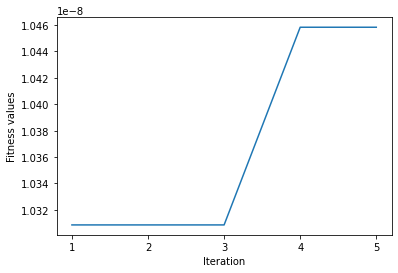

In [10]:
print(ga.F)
plt.xlabel('Iteration')
plt.ylabel('Fitness values')
plt.xticks(np.arange(1, len(ga.fit_hist)+1))
plt.plot(np.arange(1, len(ga.fit_hist)+1), np.max(ga.fit_hist, axis=1))

### Continue from ga checkpoint

In [11]:
ga = ga_main(fit, mut_level, model, x, input_scale, init_noise, r1, r2, r3, m, n, layer_idx, db_flag, maxIter, ga)

Continuing from the previous populations...

Running at iteration 6:
Average fitness value: 9.313246096098738e-09
Time taken: 116.33318877220154

Running at iteration 7:
Average fitness value: 9.163521042410139e-09
Time taken: 127.93638801574707

Running at iteration 8:
Average fitness value: 9.647302590565232e-09
Time taken: 119.96186804771423

Running at iteration 9:
Average fitness value: 9.612098551770032e-09
Time taken: 113.51935386657715

Running at iteration 10:
Average fitness value: 1.0153016319236484e-08
Time taken: 125.4926323890686



[]


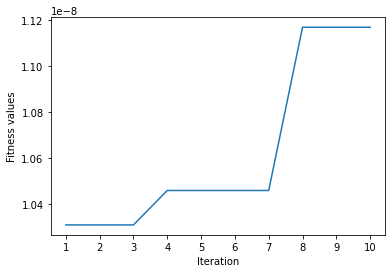

In [12]:
print(ga.F)
plt.xlabel('Iteration')
plt.ylabel('Fitness values')
plt.xticks(np.arange(1, len(ga.fit_hist)+1))
plt.plot(np.arange(1, len(ga.fit_hist)+1), np.max(ga.fit_hist, axis=1))